In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.optimize as sop
import warnings
warnings.filterwarnings('ignore')

In [2]:
mosprime3m = pd.read_csv('mosprime3m.csv',header=None,
                         index_col=0, names=['r3m'])['r3m']
mosprime3m_between = pd.read_csv('mosprime3m_between.csv', header=None,
                                 index_col=0, names=['r3m'])['r3m']
mosprime3m_short = pd.read_csv('mosprime3m_short.csv', header=None,
                               index_col=0, names=['r3m'])['r3m']

### Калибровка моделей

##### MAPE

###### Модель Мертона

\begin{align}
dr_t = \alpha dt + \sigma dW_t
\end{align}

В качестве первого метода оптимизации будем минимизировать MAPE между истинными значениями и сгенерированной траектории случайного процесса.

Для данного этапа будем пользоваться коротким временным периодом.

In [3]:
data = mosprime3m_short

Введем функцию, генерирующую траектории случайного процесса:

\begin{align*}
r_{t}-r_{t-1} = \alpha dt + \sigma \sqrt{dt} N(0,1),
\end{align*}

где $dt = \frac{1}{252}$. 

Которая будет строиться рекуррентно:

\begin{align*}
& r_{0} = r0\\
& r_{t} = r_{t-1} + \alpha dt + \sigma \sqrt{dt} N(0,1)   \quad [1]
\end{align*}

А случайная составляющая генерируется каждый раз независимо от остальных.

In [4]:
def merton_path(r0, days, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    a = a # альфа 
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = r[t - 1] +  a*dt + vol * rand[t] * np.sqrt(dt)
    merton = pd.DataFrame(r[:, 0], columns=['index'])
    merton = merton.values.flatten()
    return merton

Введем функцию потерь MAPE:

\begin{align*}
MAPE = \frac{100}{t}\sum_0^t \bigg|\frac{Y_i-F_i}{Y_i}\bigg|,
\end{align*}

где $Y_i$ - наблюдаемое значение, $F_i$ - предсказанное значение (в данном случае значение траектории [1] в момент $i$).

А также введем ограничение на неотрицательность $\sigma$.

In [5]:
def Merton_error_function(p0):
    global i, min_error
    r0 = data[0]
    a, vol = p0
    if vol < 0.0: #a < 0.0 or
        return 500.0
    se = []
    days = len(data)
    #RMSE = np.sqrt(np.nanmean((data - merton_path(r0, days, a, vol))**2))
    MAPE = 100*np.nanmean(np.absolute((data - merton_path(r0, days, a, vol))/data))
    error = MAPE
    min_error = min(min_error, error)
    #if i % 10 == 0:
        #print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (error, min_error))
    i += 1
    return error

Оптимизировать будем численными способами с помощью пакета scipy. Начальное приближение для коэффицентов зададим с помощью перебора на небольшой сетке и отборем на ней наилучший результат ошибки.

In [6]:
# Калибровка
i = 0 
min_error = 100 
p0 = sop.brute(Merton_error_function, ((0.075, 0.201, 0.025),
(0.10, 0.401, 0.1)), finish=None)
#p0 = [0.04, 0.2]
opt_merton_mape = sop.fmin(Merton_error_function, p0,
               maxiter=1000, maxfun=1000, xtol=0.00001, ftol=0.00001, disp=0)


Длу удобства введем функцию, которая будет отрисовывать траектории процесса и накладывать их на график реальных данных.

In [7]:
def m_p(data, opt, num_paths=10, alpha=0.7, title='Calibrated Merton Short Rate Simulation'):
    for i in range(num_paths):
        plt.plot(merton_path(data[0], len(data), opt[0], opt[1]),
                 lw=0.8, alpha = alpha)
    plt.title(title)
    plt.plot(data.values.flatten(), label = 'data')
    plt.legend()
    plt.tight_layout
    plt.show()

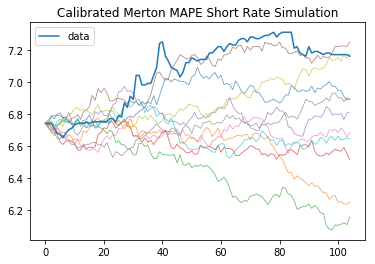

In [8]:
m_p(data, opt_merton_mape, num_paths=10, title='Calibrated Merton MAPE Short Rate Simulation')

Повторим эту операцию 100 раз и построим траектории лучшей из них.

In [9]:
def sim_opt_merton(iters):
    glob_opt = []
    glob_opt_error = 100
    for j in range(iters):
        i = 0 # counter initialization
        min_error = 100 # minimal MAPE initialization
        opt = sop.fmin(Merton_error_function, p0,
                       maxiter=1000, maxfun=1000, xtol=0.00001, ftol=0.00001, disp=0)
        if Merton_error_function(opt) < glob_opt_error:
            glob_opt_error = Merton_error_function(opt)
            glob_opt = opt
        else:
            glob_opt_error = glob_opt_error
            glob_opt = glob_opt
    return glob_opt
 

In [10]:
glob_opt = sim_opt_merton(iters=100)

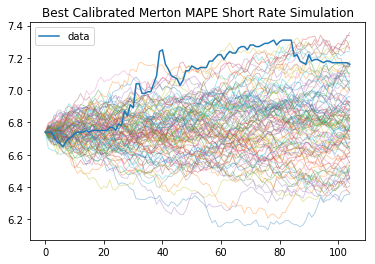

In [11]:
m_p(data, glob_opt, num_paths=100, alpha=0.4,
    title='Best Calibrated Merton MAPE Short Rate Simulation')

###### Однофакторная модель Hull-White

\begin{align*}
& dr_t = (\theta(t) - a r_t) dt + \sigma dW_t \\
& \theta(t) := \lambda + \beta t
\end{align*}

Траектории случайного процесса:

\begin{align*}
r_{t}-r_{t-1} = (\lambda + \beta t - a r_t) dt + \sigma \sqrt{dt} N(0,1),
\end{align*}


где $dt = \frac{1}{252}$. 

Которая будет строиться рекуррентно:

\begin{align*}
& r_{0} = r0\\
& r_{t} = \frac{r_{t-1} + (\lambda + \beta t) dt + \sigma \sqrt{dt} N(0,1)}{1 + \alpha dt}   
\end{align*}

А случайная составляющая генерируется каждый раз независимо от остальных.

In [12]:
def HW1_path(r0, days, l, b, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    l = l # лямбда
    a = a # альфа 
    b = b # бета
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = r[t - 1] +  (l + b * t - a * r[t - 1] ) * dt + vol * rand[t] * np.sqrt(dt)
    HW1 = pd.DataFrame(r[:, 0], columns=['index'])
    HW1 = HW1.values.flatten()
    return HW1

Аналогичным образом зададим ограничения на коэффициенты $\alpha \geq 0$ и $\sigma \geq 0$.

In [13]:
def HW1_error_function(p0):
    global i, min_error
    r0 = data[0]
    l, b, a, vol = p0
    if a < 0.0 or vol < 0.0 : #or b < 0.0 or l < 0.0
        return 500.0
    se = []
    days = len(data)
    #RMSE = np.sqrt(np.nanmean((data - HW1_path(r0, days, l, b, a, vol))**2))
    MAPE = 100*np.nanmean(np.absolute((data - HW1_path(r0, days, l, b, a, vol))/data))
    error = MAPE
    min_error = min(min_error, error)
    #if i % 10 == 0:
        #print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (error, min_error))
    i += 1
    return error

In [14]:

i = 0 
min_error = 100 
p0 = sop.brute(HW1_error_function, ((0.10, 0.401, 0.1),
                                    (0.0001, 0.101, 0.025),
                                    (0.075, 0.201, 0.025),
                                    (0.075, 0.201, 0.025)), finish=None)
opt_HW1_error = sop.fmin(HW1_error_function, p0,
               maxiter=1000, maxfun=1000, xtol=0.00001, ftol=0.00001, disp=0)

In [15]:
def HW1_p(data, opt, num_paths=10, alpha=0.7, title='Calibrated HW1 Short Rate Simulation'):
    for i in range(num_paths):
        plt.plot(HW1_path(data[0], len(data), opt[0], opt[1],
                      opt[2], opt[3]), lw=0.8, alpha=alpha)
    plt.title(title)
    plt.plot(data.values.flatten(), label = 'data')
    plt.legend()
    plt.tight_layout
    plt.show()

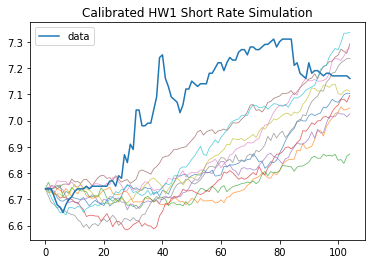

In [16]:
HW1_p(data, opt_HW1_error, num_paths=10, alpha=0.7, title='Calibrated HW1 Short Rate Simulation')

In [17]:
def sim_opt_HW1(iters):
    glob_opt = []
    glob_opt_error = 100
    for j in range(iters):
        i = 0 # counter initialization
        min_error = 100 # minimal MAPE initialization
        opt = sop.fmin(HW1_error_function, p0,
                       maxiter=1000, maxfun=1000, xtol=0.00001, ftol=0.00001, disp=0)
        if HW1_error_function(opt) < glob_opt_error:
            glob_opt_error = HW1_error_function(opt)
            glob_opt = opt
        else:
            glob_opt_error = glob_opt_error
            glob_opt = glob_opt
    return glob_opt
 

In [18]:
glob_opt_HW1 = sim_opt_HW1(iters=100)

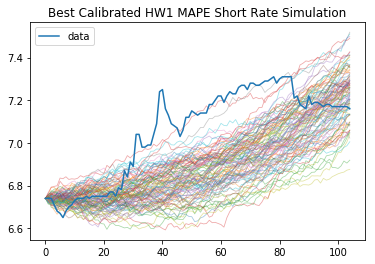

In [19]:
HW1_p(data, glob_opt_HW1, num_paths=100, alpha=0.4,
      title='Best Calibrated HW1 MAPE Short Rate Simulation')

In [20]:
glob_opt_HW1

array([0.41501199, 0.02654124, 0.09925983, 0.19723567])